In [188]:
from time import time
import casadi as ca
import numpy as np
import matplotlib.pyplot as plt

In [189]:

T = 0.2     # sampling time
N = 3       # prediction horizon

v_max = 0.6
v_min = -v_max

omega_max = ca.pi/4
omega_min = -omega_max


################
# Robot state
################
x = ca.SX.sym('x')
y = ca.SX.sym('y')
theta = ca.SX.sym('theta')

states = ca.vertcat(        # concat the matrice or vector vertically
    x,
    y,
    theta
)
n_states = states.numel()   # The number of elements

################
# Robot control
################
v = ca.SX.sym('v')
omega = ca.SX.sym('omega')

controls = ca.vertcat(        # concat the matrice or vector vertically
    v,
    omega
)
n_controls = controls.numel()   # The number of elements

# Define the right hand function
rhs = ca.vertcat(
    v*ca.cos(theta),
    v*ca.sin(theta),
    omega
)

# TODO : this represents the f function
## define non linear mapping function
def apply_dynamics(states, controls):
    return rhs

f = ca.Function('f', [states,controls],[rhs])

# Decision variables
U = ca.SX.sym('U', n_controls, N)   # controls
P = ca.SX.sym('P', n_states+n_states) # initial and reference state of the robot

# Matrix of the states over the optimization problem
X = ca.SX.sym('X', n_states, N+1)


In [190]:
print(P[0:3])
print(X)
print(X[:,0])

[P_0, P_1, P_2]

[[X_0, X_3, X_6, X_9], 
 [X_1, X_4, X_7, X_10], 
 [X_2, X_5, X_8, X_11]]
[X_0, X_1, X_2]


In [191]:
# compute the solution symbolically
X[:,0] = P[0:3]

for k in range(N):
    print(k)
    st = X[:,k]
    con = U[:,k]
    f_value = f(st, con)
    st_next = st + (T*f_value)
    X[:,k+1]=st_next

print(X)

# get optimal trajectory knowing the optimal solution
ff=ca.Function('ff', [U,P], [X])
def get_op_trajectory(U,P):
    return X

0
1
2
@1=0.2, @2=(P_0+(@1*(U_0*cos(P_2)))), @3=(P_1+(@1*(U_0*sin(P_2)))), @4=(P_2+(@1*U_1)), @5=(@2+(@1*(U_2*cos(@4)))), @6=(@3+(@1*(U_2*sin(@4)))), @7=(@4+(@1*U_3)), 
[[P_0, @2, @5, (@5+(@1*(U_4*cos(@7))))], 
 [P_1, @3, @6, (@6+(@1*(U_4*sin(@7))))], 
 [P_2, @4, @7, (@7+(@1*U_5))]]


In [192]:
print(np.zeros((3,3)))
print(np.diag((1,5, 0.1)))

[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[[1.  0.  0. ]
 [0.  5.  0. ]
 [0.  0.  0.1]]


In [193]:

###############################


g = [] # optimization constraints : empty
# P = [] # optimization problem parameters : empty

# weighing matrices states
Q = np.diag((1, 5, 0.1))
# weighing matrices controls
R = np.diag((0.5, 0.05))

obj = 0 # Calcul of the objective
## compute the obj function
for k in range(N):
    print(k)
    st = X[:,k]
    con = U[:,k]
    obj = obj + (st-P[3:6]).T@Q@(st-P[3:6])+con.T@R@con
print(obj)

0
1
2
@1=5, @2=0.1, @3=0.5, @4=0.05, @5=0.2, @6=(P_0+(@5*(U_0*cos(P_2)))), @7=(P_1+(@5*(U_0*sin(P_2)))), @8=(P_2+(@5*U_1)), @9=(@7+(@5*(U_2*sin(@8)))), @10=(@8+(@5*U_3)), (((((((sq((P_0-P_3))+((@1*(P_1-P_4))*(P_1-P_4)))+((@2*(P_2-P_5))*(P_2-P_5)))+(((@3*U_0)*U_0)+((@4*U_1)*U_1)))+((sq((@6-P_3))+((@1*(@7-P_4))*(@7-P_4)))+((@2*(@8-P_5))*(@8-P_5))))+(((@3*U_2)*U_2)+((@4*U_3)*U_3)))+((sq(((@6+(@5*(U_2*cos(@8))))-P_3))+((@1*(@9-P_4))*(@9-P_4)))+((@2*(@10-P_5))*(@10-P_5))))+(((@3*U_4)*U_4)+((@4*U_5)*U_5)))


In [194]:
# compute constraints
for k in range(N):
    print(k)
    g = ca.vertcat(g, X[1,k]) #state x
    g = ca.vertcat(g, X[2,k]) #state y
print(g)

0
1
2
@1=0.2, @2=(P_1+(@1*(U_0*sin(P_2)))), @3=(P_2+(@1*U_1)), [P_1, P_2, @2, @3, (@2+(@1*(U_2*sin(@3)))), (@3+(@1*U_3))]


In [195]:

# make the decision variables one column vector
OPT_variables = U.reshape((-1,1))
nlp_prob = {'f':obj, 'x':OPT_variables, 'g':g, 'p':P}

opts = {
    'ipopt': # interior point optimizer
    {
        'max_iter':100,
        'print_level':0,
        'acceptable_tol':1e-8,
        'acceptable_obj_change_tol':1e-6
    },
    'print_time':0,
}
solver = ca.nlpsol('solver','ipopt', nlp_prob, opts)
print(nlp_prob)

{'f': SX(@1=5, @2=0.1, @3=0.5, @4=0.05, @5=0.2, @6=(P_0+(@5*(U_0*cos(P_2)))), @7=(P_1+(@5*(U_0*sin(P_2)))), @8=(P_2+(@5*U_1)), @9=(@7+(@5*(U_2*sin(@8)))), @10=(@8+(@5*U_3)), (((((((sq((P_0-P_3))+((@1*(P_1-P_4))*(P_1-P_4)))+((@2*(P_2-P_5))*(P_2-P_5)))+(((@3*U_0)*U_0)+((@4*U_1)*U_1)))+((sq((@6-P_3))+((@1*(@7-P_4))*(@7-P_4)))+((@2*(@8-P_5))*(@8-P_5))))+(((@3*U_2)*U_2)+((@4*U_3)*U_3)))+((sq(((@6+(@5*(U_2*cos(@8))))-P_3))+((@1*(@9-P_4))*(@9-P_4)))+((@2*(@10-P_5))*(@10-P_5))))+(((@3*U_4)*U_4)+((@4*U_5)*U_5)))), 'x': SX([U_0, U_1, U_2, U_3, U_4, U_5]), 'g': SX(@1=0.2, @2=(P_1+(@1*(U_0*sin(P_2)))), @3=(P_2+(@1*U_1)), [P_1, P_2, @2, @3, (@2+(@1*(U_2*sin(@3)))), (@3+(@1*U_3))]), 'p': SX([P_0, P_1, P_2, P_3, P_4, P_5])}


In [218]:

t0 = 0
t = []
x0 = ca.DM.zeros(n_states)
print(x0.shape)
xs = [1.5,1.5,0]
u0 = ca.DM.zeros((N,2))
print(u0)
sim_time = 20
mpciter = 0
xx1 = np.zeros((n_states,N+1, int(sim_time/T)))
xx = np.zeros((n_states,int(sim_time/T)))
xx[:,0]=x0.full().reshape((-1,))
u_cl = []
print(np.shape(xx))
print(sim_time/T)

args = {
    'lbx' : [v_min, omega_min]*N,
    'ubx' : [v_max, omega_max]*N,
    'lbg' : -2,
    'ubg' : 2,
    'p': ca.vertcat(x0,xs),
    'x0': u0.T.reshape((-1,1))
}

(3, 1)

[[0, 0], 
 [0, 0], 
 [0, 0]]
(3, 100)
100.0


In [197]:
def shift(step_horizon, t0, state_init, u, f):
    f_value = f(state_init, u[:, 0])
    next_state = ca.DM.full(state_init + (step_horizon * f_value))

    t0 = t0 + step_horizon
    u0 = ca.horzcat(
        u[:, 1:],
        ca.reshape(u[:, -1], -1, 1)
    )

    return t0, next_state, u0


In [198]:
while (ca.norm_2(x0[:,0] - xs).full() > 1e-2)[0] and (mpciter <= (sim_time / T)):
    args['p'] = ca.vertcat(x0,xs)
    args['x0'] = u0.T.reshape((-1,1))
    sol = solver(**args)
    u_opt = ca.reshape(sol['x'].full(), 2, -1)
    ff_value = ff(u_opt, args['p']) # compute optimal solution trajectory
    xx1[:,range(N+1),mpciter-1] = ff_value.full()
    u_cl = ca.vertcat(u_cl, u_opt[:,0])
    t.append(t0)
    t0, x0, u0 = shift(T, t0, x0, u_opt, f)
    print("---x0 ",x0)
    print("---", mpciter)
    print(xx[:,mpciter-1])
    xx[:,mpciter-1] = x0.reshape((-1,))
    mpciter = mpciter+1

---x0  [[0.12      ]
 [0.        ]
 [0.15707963]]
--- 0
[0. 0. 0.]
---x0  [[0.2385226 ]
 [0.01877214]
 [0.31415926]]
--- 1
[0. 0. 0.]
---x0  [[0.35264939]
 [0.05585418]
 [0.4712389 ]]
--- 2
[0. 0. 0.]
---x0  [[0.45957017]
 [0.11033304]
 [0.62831852]]
--- 3
[0. 0. 0.]
---x0  [[0.55665221]
 [0.18086727]
 [0.78539815]]
--- 4
[0. 0. 0.]
---x0  [[0.64150503]
 [0.26572008]
 [0.91686707]]
--- 5
[0. 0. 0.]
---x0  [[0.7145022 ]
 [0.36096405]
 [0.98396615]]
--- 6
[0. 0. 0.]
---x0  [[0.78094912]
 [0.46088806]
 [1.01277367]]
--- 7
[0. 0. 0.]
---x0  [[0.8444903 ]
 [0.56268452]
 [1.01800842]]
--- 8
[0. 0. 0.]
---x0  [[0.90749773]
 [0.6648122 ]
 [1.00779816]]
--- 9
[0. 0. 0.]
---x0  [[0.97154462]
 [0.76629125]
 [0.98653728]]
--- 10
[0. 0. 0.]
---x0  [[1.0377344 ]
 [0.86638577]
 [0.95649669]]
--- 11
[0. 0. 0.]
---x0  [[1.10690076]
 [0.96444705]
 [0.91872167]]
--- 12
[0. 0. 0.]
---x0  [[1.17972116]
 [1.05982623]
 [0.87329607]]
--- 13
[0. 0. 0.]
---x0  [[1.25679762]
 [1.15180026]
 [0.81011417]]
--- 14
[

In [199]:
import numpy as np 
from numpy import sin, cos, pi
import matplotlib.pyplot as plt
from matplotlib import animation
from time import time


def simulate(cat_states, cat_controls, t, step_horizon, N, reference, save=False):
    def create_triangle(state=[0,0,0], h=1, w=0.5, update=False):
        x, y, th = state
        triangle = np.array([
            [h, 0   ],
            [0,  w/2],
            [0, -w/2],
            [h, 0   ]
        ]).T
        rotation_matrix = np.array([
            [cos(th), -sin(th)],
            [sin(th),  cos(th)]
        ])

        coords = np.array([[x, y]]) + (rotation_matrix @ triangle).T
        if update == True:
            return coords
        else:
            return coords[:3, :]

    def init():
        return path, horizon, current_state, target_state,

    def animate(i):
        # get variables
        x = cat_states[0, 0, i]
        y = cat_states[1, 0, i]
        th = cat_states[2, 0, i]

        # update path
        if i == 0:
            path.set_data(np.array([]), np.array([]))
        x_new = np.hstack((path.get_xdata(), x))
        y_new = np.hstack((path.get_ydata(), y))
        path.set_data(x_new, y_new)

        # update horizon
        x_new = cat_states[0, :, i]
        y_new = cat_states[1, :, i]
        horizon.set_data(x_new, y_new)

        # update current_state
        current_state.set_xy(create_triangle([x, y, th], update=True))

        # update target_state
        # xy = target_state.get_xy()
        # target_state.set_xy(xy)            

        return path, horizon, current_state, target_state,

    # create figure and axes
    fig, ax = plt.subplots(figsize=(6, 6))
    min_scale = min(reference[0], reference[1], reference[3], reference[4]) - 2
    max_scale = max(reference[0], reference[1], reference[3], reference[4]) + 2
    ax.set_xlim(left = min_scale, right = max_scale)
    ax.set_ylim(bottom = min_scale, top = max_scale)

    # create lines:
    #   path
    path, = ax.plot([], [], 'k', linewidth=2)
    #   horizon
    horizon, = ax.plot([], [], 'x-g', alpha=0.5)
    #   current_state
    current_triangle = create_triangle(reference[:3])
    current_state = ax.fill(current_triangle[:, 0], current_triangle[:, 1], color='r')
    current_state = current_state[0]
    #   target_state
    target_triangle = create_triangle(reference[3:])
    target_state = ax.fill(target_triangle[:, 0], target_triangle[:, 1], color='b')
    target_state = target_state[0]

    sim = animation.FuncAnimation(
        fig=fig,
        func=animate,
        init_func=init,
        frames=len(t),
        interval=step_horizon*100,
        blit=True,
        repeat=True
    )
    plt.show()

    if save == True:
        sim.save('./animation' + str(time()) +'.gif', writer='ffmpeg', fps=30)

    return



0.0


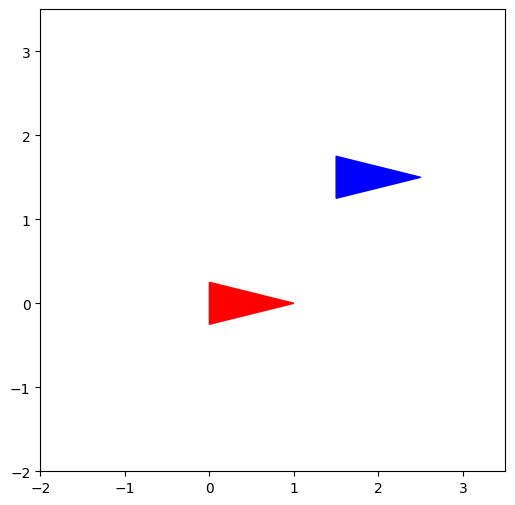

In [222]:
reference = [0.,0.,0.,1.5,1.5,0.]
print(reference[0])
simulate(xx, u_cl, [sim_time]*20, T, N,reference)